<a href="https://colab.research.google.com/github/drdosan/cap1-farmtech-na-era-cloud/blob/main/src/DiogoRebello_rm565286_pbl_fase4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# FarmTech Solutions — Fase 5 (ML + Cloud)

**Autor:** Diogo Rebello e Vera Chaves

**Notebook gerado:** 2025-09-01 04:14:33

Este notebook cobre:
- Análise exploratória (EDA)
- Clusterização (KMeans + PCA 2D) e detecção de outliers (IsolationForest)
- **5 modelos de regressão**: Regressão Linear, Árvore de Decisão, KNN, Floresta Aleatória, **XGBoost**
- Comparação por **MAE, RMSE e R²**
- Export do melhor modelo para `artifacts/best_model.joblib`

> **Instruções:** Coloque o arquivo `crop_yield.csv` na mesma pasta do notebook ao executar localmente. Renomeie este arquivo para incluir seu RM antes de subir ao GitHub.


In [8]:

# ===== Setup =====
import os, math, joblib, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# sklearn
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# modelos
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from xgboost import XGBRegressor

# clusterização
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

plt.ioff()  # evitar muitos popups

ROOT = Path('.')
FIG_DIR = ROOT / 'figures'
ART_DIR = ROOT / 'artifacts'
FIG_DIR.mkdir(exist_ok=True, parents=True)
ART_DIR.mkdir(exist_ok=True, parents=True)

CSV_PATH = ROOT / 'crop_yield.csv'
assert CSV_PATH.exists(), f'CSV não encontrado em {CSV_PATH}'
print('CSV:', CSV_PATH.resolve())


CSV: /content/crop_yield.csv


In [9]:

# ===== Carregar e padronizar colunas =====
df = pd.read_csv(CSV_PATH)

rename_map = {
    'Crop': 'crop',
    'Precipitation (mm day-1)': 'precip_mm_day',
    'Specific Humidity at 2 Meters (g/kg)': 'spec_humidity_gkg',
    'Relative Humidity at 2 Meters (%)': 'rel_humidity_pct',
    'Temperature at 2 Meters (C)': 'temp_c',
    'Yield': 'yield_t_ha'
}
df = df.rename(columns=rename_map)

num_cols = ['precip_mm_day', 'spec_humidity_gkg', 'rel_humidity_pct', 'temp_c']
cat_cols = ['crop']
target = 'yield_t_ha'

display(df.head())
print('Shape:', df.shape)
print('Tipos:\n', df.dtypes)
print('Missing por coluna:\n', df.isna().sum())


,crop,precip_mm_day,spec_humidity_gkg,rel_humidity_pct,temp_c,yield_t_ha
0,"Cocoa, beans",2248.92,17.72,83.40,26.01,11560
1,"Cocoa, beans",1938.42,17.54,82.11,26.11,11253
2,"Cocoa, beans",2301.54,17.81,82.79,26.24,9456
3,"Cocoa, beans",2592.35,17.61,85.07,25.56,9321
4,"Cocoa, beans",2344.72,17.61,84.12,25.76,8800


Shape: (156, 6)
Tipos:
 crop                  object
precip_mm_day        float64
spec_humidity_gkg    float64
rel_humidity_pct     float64
temp_c               float64
yield_t_ha             int64
dtype: object
Missing por coluna:
 crop                 0
precip_mm_day        0
spec_humidity_gkg    0
rel_humidity_pct     0
temp_c               0
yield_t_ha           0
dtype: int64


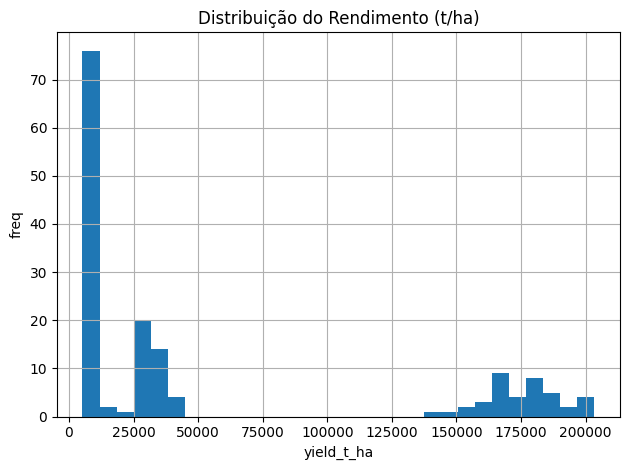

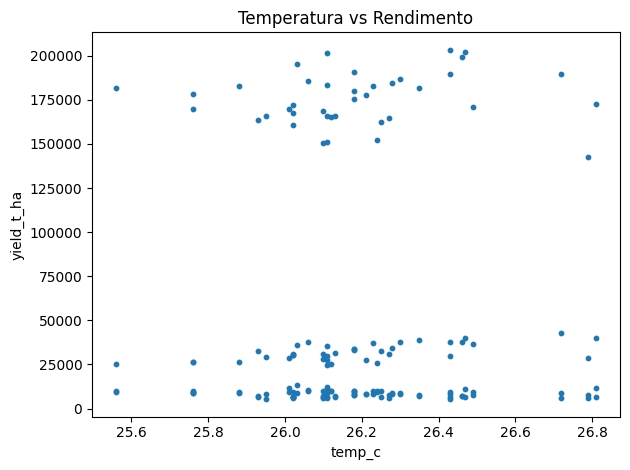

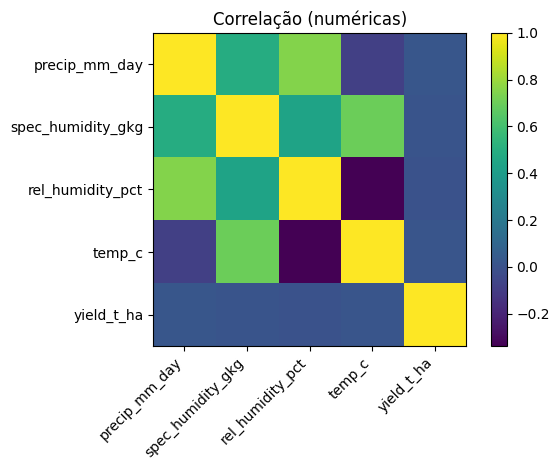

,yield_t_ha
yield_t_ha,1.000000
precip_mm_day,0.018830
temp_c,0.013007
spec_humidity_gkg,0.012651
rel_humidity_pct,0.000008


In [10]:

# ===== EDA =====
# Histograma do target
plt.figure()
df[target].hist(bins=30)
plt.title('Distribuição do Rendimento (t/ha)')
plt.xlabel(target); plt.ylabel('freq')
plt.tight_layout(); plt.savefig(FIG_DIR / 'hist_yield.png'); plt.show()

# Dispersão temperatura x yield
plt.figure()
plt.scatter(df['temp_c'], df[target], s=10)
plt.title('Temperatura vs Rendimento')
plt.xlabel('temp_c'); plt.ylabel(target)
plt.tight_layout(); plt.savefig(FIG_DIR / 'scatter_temp_yield.png'); plt.show()

# Correlação numérica
corr = df[num_cols + [target]].corr(numeric_only=True)
plt.figure()
plt.imshow(corr, interpolation='nearest')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha='right')
plt.yticks(range(len(corr.index)), corr.index)
plt.colorbar()
plt.title('Correlação (numéricas)')
plt.tight_layout(); plt.savefig(FIG_DIR / 'corr_matrix.png'); plt.show()

corr[target].sort_values(ascending=False)


Silhouette por k: {2: np.float64(0.392), 3: np.float64(0.435), 4: np.float64(0.44)} | melhor k = 4


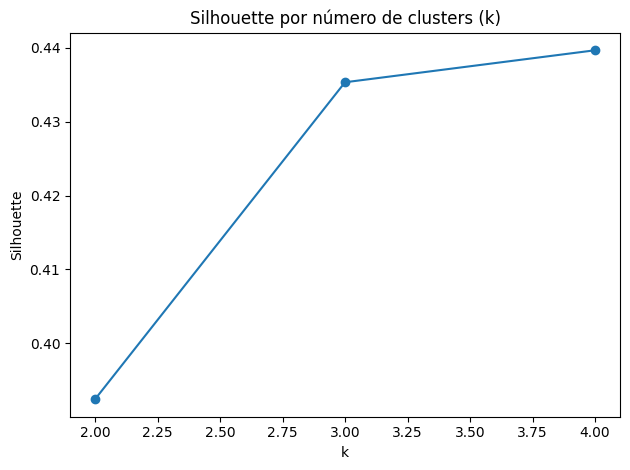

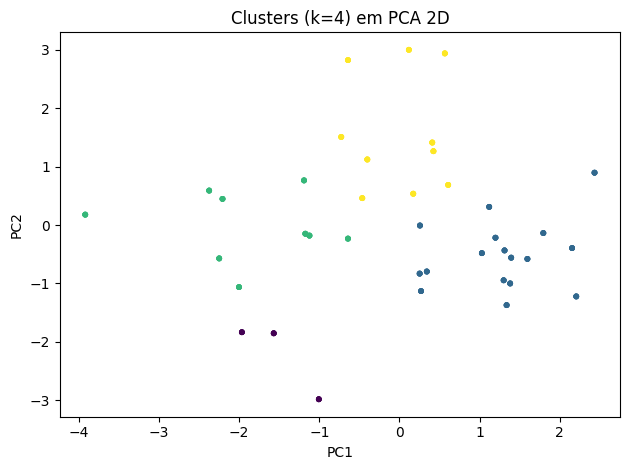

Outliers detectados: 0


,crop,yield_t_ha,precip_mm_day,spec_humidity_gkg,rel_humidity_pct,temp_c


In [11]:

# ===== Clusterização (KMeans) + PCA 2D =====
X_cluster = df[num_cols].copy().values
X_scaled = StandardScaler().fit_transform(X_cluster)

k_opts = [2,3,4]
scores = []
for k in k_opts:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    scores.append(silhouette_score(X_scaled, labels))

best_k = int(k_opts[int(np.argmax(scores))])
print('Silhouette por k:', dict(zip(k_opts, np.round(scores, 3))), '| melhor k =', best_k)

plt.figure()
plt.plot(k_opts, scores, marker='o')
plt.title('Silhouette por número de clusters (k)')
plt.xlabel('k'); plt.ylabel('Silhouette')
plt.tight_layout(); plt.savefig(FIG_DIR / 'silhouette_k.png'); plt.show()

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
km = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels = km.fit_predict(X_scaled)

plt.figure()
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, s=10)
plt.title(f'Clusters (k={best_k}) em PCA 2D')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.tight_layout(); plt.savefig(FIG_DIR / 'clusters_pca.png'); plt.show()

# Outliers (IsolationForest ~1%)
iso = IsolationForest(random_state=42, contamination=0.01)
anom = iso.fit_predict(X_scaled)  # -1 anômalo
df['is_outlier'] = (anom == -1)
print('Outliers detectados:', int(df['is_outlier'].sum()))
display(df[df['is_outlier']][['crop', target] + num_cols].head())


,model,MAE,RMSE,R2
0,RandomForest,4361.694167,8010.668914,0.987188
1,LinearRegression,5089.299132,8038.746820,0.986960
2,DecisionTree,4944.647436,9155.945168,0.982639
3,XGBoost,5481.045410,9283.987218,0.982982
4,KNN,19868.287179,35234.894813,0.753429


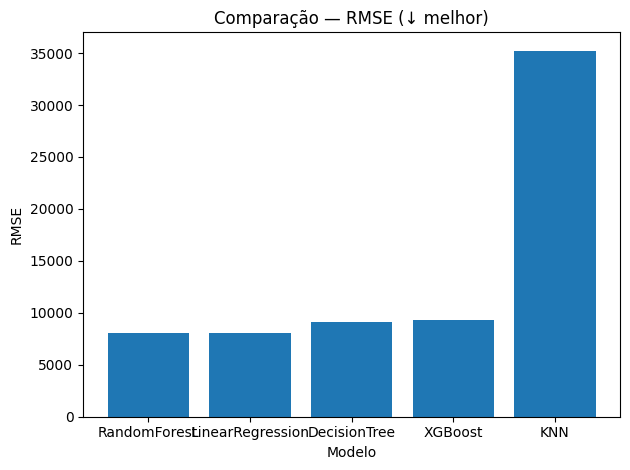

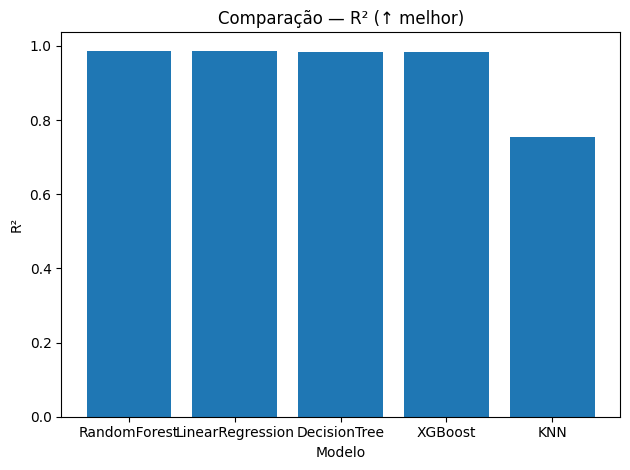

Melhor modelo: RandomForest | salvo em artifacts/best_model.joblib


In [12]:

# ===== Modelagem Supervisionada (5 algoritmos) =====
from math import sqrt

X = df[cat_cols + num_cols]
y = df[target]

# Pré-processamento: OneHot(categorias) + Imputer/Scaler(numéricas)
preprocess = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('num', Pipeline([('imputer', SimpleImputer(strategy='median')),
                      ('scaler', StandardScaler())]), num_cols)
])

models = {
    'LinearRegression': LinearRegression(),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'KNN': KNeighborsRegressor(n_neighbors=5),
    'RandomForest': RandomForestRegressor(n_estimators=200, random_state=42),
    'XGBoost': XGBRegressor(
        n_estimators=300, learning_rate=0.1, max_depth=5,
        subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
        random_state=42, objective='reg:squarederror', n_jobs=1
    )
}

def evaluate_model(name, model):
    pipe = Pipeline(steps=[('prep', preprocess), ('model', model)])
    kf = KFold(n_splits=3, shuffle=True, random_state=42)  # 3-fold p/ execução rápida
    mae = -cross_val_score(pipe, X, y, scoring='neg_mean_absolute_error', cv=kf).mean()
    rmse = np.sqrt(-cross_val_score(pipe, X, y, scoring='neg_mean_squared_error', cv=kf).mean())
    r2 = cross_val_score(pipe, X, y, scoring='r2', cv=kf).mean()
    return {'model': name, 'MAE': mae, 'RMSE': rmse, 'R2': r2}

results = [evaluate_model(n, m) for n, m in models.items()]
res_df = pd.DataFrame(results).sort_values('RMSE').reset_index(drop=True)
display(res_df)

# Gráficos simples
plt.figure(); plt.bar(res_df['model'], res_df['RMSE']); plt.title('Comparação — RMSE (↓ melhor)'); plt.xlabel('Modelo'); plt.ylabel('RMSE'); plt.tight_layout(); plt.savefig(FIG_DIR / 'model_rmse.png'); plt.show()
plt.figure(); plt.bar(res_df['model'], res_df['R2']); plt.title('Comparação — R² (↑ melhor)'); plt.xlabel('Modelo'); plt.ylabel('R²'); plt.tight_layout(); plt.savefig(FIG_DIR / 'model_r2.png'); plt.show()

best_name = res_df.iloc[0]['model']
best_model = models[best_name]
best_pipe = Pipeline(steps=[('prep', preprocess), ('model', best_model)]).fit(X, y)
joblib.dump(best_pipe, ART_DIR / 'best_model.joblib')
print('Melhor modelo:', best_name, '| salvo em artifacts/best_model.joblib')


In [13]:

# ===== Demonstração de predição =====
loaded = joblib.load(ART_DIR / 'best_model.joblib')

# exemplo: usar a primeira linha como template e alterar valores
ex = df.iloc[[0]][cat_cols + num_cols].copy()
ex.loc[:, 'temp_c'] = ex['temp_c'].values + 1.0  # simular cenário mais quente
pred = loaded.predict(ex)[0]
print('Predição (t/ha) para o exemplo sintetizado:', round(float(pred), 2))


Predição (t/ha) para o exemplo sintetizado: 10638.89



## Conclusões
- **Clusterização (KMeans)** evidenciou perfis de produtividade distintos; visualizamos em 2D via **PCA**.
- **Outliers** (~1%) identificados por **IsolationForest** podem indicar leituras atípicas, erros de sensor ou microclimas.
- Comparamos **Regressão Linear, Árvore de Decisão, KNN, RandomForest e XGBoost** com **MAE, RMSE e R²** usando *pipelines* e *cross-validation*.
- O melhor modelo (ver tabela/gráficos) foi exportado para `artifacts/best_model.joblib`.

**Próximos passos**
- *TimeSeriesSplit* (se houver componente temporal), *tuning* de hiperparâmetros (Grid/Random/Bayes), novas features (sazonalidade, tipo de solo, latitude/longitude).


In [14]:

# ===== Apêndice: versões =====
import sklearn, xgboost, platform
print('Python:', platform.python_version())
print('sklearn:', sklearn.__version__)
print('xgboost:', xgboost.__version__)


Python: 3.12.11
sklearn: 1.6.1
xgboost: 3.0.4
